<center><h1>Masked Language Modeling Using Transformers</h1></center>

## Import librairies

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import transformers
from transformers import pipeline
import warnings
from transformers import logging
logging.set_verbosity_error()
warnings.filterwarnings('ignore')

## Import Dataset

In [2]:
eval_df = pd.read_excel("../../Datasets/text_mining_results.xlsx")
eval_df.head()

,target sentence,noisy sentence1,noisy sentence2,common_sentence,uncommon_target_sentence,uncommon_sentence1,uncommon_sentence2,Is correct
0,A man with a hard hat is dancing.,A CAN WHET a GERARD hat is dancing.,A man with a hard hat is dancing.,a [MASK] [MASK] a [MASK] hat is dancing,"['man', 'with', 'hard']","['can', 'whet', 'gerard']","['man', 'with', 'hard']",Correct
1,A young child is riding a horse.,A young child is REDDING a horse.,A young TILED WIZ riding IO horse.,a young [MASK] [MASK] [MASK] [MASK] horse,"['child', 'is', 'riding', 'a']","['child', 'is', 'redding', 'a']","['tiled', 'wiz', 'riding', 'io']",Correct
2,A man is feeding a mouse to a snake.,A man is feeding IO mouse to IO snake.,A CAN is feeding a mouse to a snake.,a [MASK] is feeding [MASK] mouse to [MASK] snake,"['man', 'a', 'a']","['man', 'io', 'io']","['can', 'a', 'a']",Correct
3,A woman is playing the guitar.,A woman is playing the guitar.,A WAYMAN WIZ SWAYING TU guitar.,a [MASK] [MASK] [MASK] [MASK] guitar,"['woman', 'is', 'playing', 'the']","['woman', 'is', 'playing', 'the']","['wayman', 'wiz', 'swaying', 'tu']",Correct
4,A woman is playing the flute.,A WAYMAN WIZ SWAYING TU flute.,A woman is playing the flute.,a [MASK] [MASK] [MASK] [MASK] flute,"['woman', 'is', 'playing', 'the']","['wayman', 'wiz', 'swaying', 'tu']","['woman', 'is', 'playing', 'the']",Correct


In [3]:
masked_sentences = eval_df["common_sentence"].to_numpy()
real_pred = eval_df["uncommon_target_sentence"].to_numpy()

## Evaluation function

In [4]:
def remove_all(liste, value):
    while value in liste:
        liste.remove(value)
    return liste

def similarity(word, list_of_words):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get the synsets of the word
    synsets_word = wn.synsets(lemmatizer.lemmatize(word))

    # Calculate the similarity between the word and each word in the list
    similarities = []
    for w in list_of_words:
        synsets_w = wn.synsets(lemmatizer.lemmatize(w))
        max_sim = 0
        for synset_word in synsets_word:
            for synset_w in synsets_w:
                sim = synset_word.path_similarity(synset_w)
                if sim is not None and sim > max_sim:
                    max_sim = sim
        similarities.append(max_sim)

    if word in list_of_words:
        similarities.append(1)

    # Print the list of similarities
    return np.max(similarities)

## BERT

In [204]:
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

In [211]:
# 34 min 11.3 s
df_bert = []
for i in range(len(masked_sentences)):
    print(str(i+1) + "/" + str(len(masked_sentences)))
    ms = masked_sentences[i]
    r_pred = nltk.RegexpTokenizer(r'\w+').tokenize(real_pred[i])
    number_of_masks = len(r_pred)
    for j in range(number_of_masks):
        pred = fill_mask(ms)
        if type(pred[0]) == list:
            df1 = pd.DataFrame(pred[0])
        else:
            df1 = pd.DataFrame(pred) # Convert the prediction to a dataframe
        word_list = df1["token_str"].tolist() # Get the list of words from the dataframe

        df_bert.append([ms, r_pred[j], word_list])
        ms = ms.replace("[MASK]", r_pred[j], 1)

df_bert = pd.DataFrame(df_bert, columns=["Masked sentence","real", "pred"])
df_bert.head()

,Masked sentence,real,pred
0,a [MASK] [MASK] a [MASK] hat is dancing,man,"[woman, man, girl, boy, lady]"
1,a man [MASK] a [MASK] hat is dancing,with,"[in, wearing, with, without, under]"
2,a man with a [MASK] hat is dancing,hard,"[straw, cowboy, bowler, top, red]"
3,a young [MASK] [MASK] [MASK] [MASK] horse,child,"[woman, man, girl, boy, horse]"
4,a young child [MASK] [MASK] [MASK] horse,is,"[., with, riding, ,, and]"


In [210]:
df_bert.to_excel("../../Datasets/bert-base-uncased.xlsx", index=False)

In [212]:
real = df_bert["real"].to_numpy()
pred = df_bert["pred"].to_numpy()
acc = []
for i in range(len(pred)):
    acc.append(similarity(real[i], pred[i]))
print("Accuracy: {:.2f}".format(np.mean(acc)))

df_bert_copy = df_bert.copy()
df_bert_copy["similarity"] = acc
df_bert_copy.to_excel("../../Datasets/bert-base_pred_with_acc.xlsx", index=False)

Accuracy: 0.44


## Roberta

In [15]:
fill_mask = pipeline("fill-mask", model="roberta-base")

In [16]:
# 36 min 9.9s
df_roberta = []
for i in range(len(masked_sentences)):
    print(str(i+1) + "/" + str(len(masked_sentences)))
    ms = masked_sentences[i].replace("[MASK]", "<mask>")
    r_pred = nltk.RegexpTokenizer(r'\w+').tokenize(real_pred[i])
    number_of_masks = len(r_pred)
    for j in range(number_of_masks):
        pred = fill_mask(ms)
        if type(pred[0]) == list:
            df1 = pd.DataFrame(pred[0])
        else:
            df1 = pd.DataFrame(pred) # Convert the prediction to a dataframe
        word_list = df1["token_str"].tolist() # Get the list of words from the dataframe

        df_roberta.append([ms, r_pred[j], word_list])
        ms = ms.replace("<mask>", r_pred[j], 1)

df_roberta = pd.DataFrame(df_roberta, columns=["Masked sentence", "real", "pred"])
df_roberta.head()

1/3006
2/3006
3/3006
4/3006
5/3006
6/3006
7/3006
8/3006
9/3006
10/3006
11/3006
12/3006
13/3006
14/3006
15/3006
16/3006
17/3006
18/3006
19/3006
20/3006
21/3006
22/3006
23/3006
24/3006
25/3006
26/3006
27/3006
28/3006
29/3006
30/3006
31/3006
32/3006
33/3006
34/3006
35/3006
36/3006
37/3006
38/3006
39/3006
40/3006
41/3006
42/3006
43/3006
44/3006
45/3006
46/3006
47/3006
48/3006
49/3006
50/3006
51/3006
52/3006
53/3006
54/3006
55/3006
56/3006
57/3006
58/3006
59/3006
60/3006
61/3006
62/3006
63/3006
64/3006
65/3006
66/3006
67/3006
68/3006
69/3006
70/3006
71/3006
72/3006
73/3006
74/3006
75/3006
76/3006
77/3006
78/3006
79/3006
80/3006
81/3006
82/3006
83/3006
84/3006
85/3006
86/3006
87/3006
88/3006
89/3006
90/3006
91/3006
92/3006
93/3006
94/3006
95/3006
96/3006
97/3006
98/3006
99/3006
100/3006
101/3006
102/3006
103/3006
104/3006
105/3006
106/3006
107/3006
108/3006
109/3006
110/3006
111/3006
112/3006
113/3006
114/3006
115/3006
116/3006
117/3006
118/3006
119/3006
120/3006
121/3006
122/3006
123/3006
1

,Masked sentence,real,pred
0,a <mask> <mask> a <mask> hat is dancing,man,"[ man, guy, woman, girl, boy]"
1,a man <mask> a <mask> hat is dancing,with,"[ in, wearing, with, sporting, without]"
2,a man with a <mask> hat is dancing,hard,"[ cowboy, top, straw, Santa, red]"
3,a young <mask> <mask> <mask> <mask> horse,child,"[ boy, man, girl, male, horse]"
4,a young child <mask> <mask> <mask> horse,is,"[ riding, on, with, rides, sitting]"


In [17]:
df_roberta.to_excel("../../Datasets/roberta-base_pred.xlsx", index=False)

In [18]:
real = df_roberta["real"].to_numpy()
pred = df_roberta["pred"].to_numpy()

new_pred = []
for l in range(len(pred)):
    new_pred.append(remove_all(" ".join(pred[l]).split(" "), ""))

acc = []
for i in range(len(pred)):
    acc.append(similarity(real[i], new_pred[i]))
print("Accuracy: {:.2f}".format(np.mean(acc)))

df_roberta_copy = df_roberta.copy()
df_roberta_copy["similarity"] = acc
df_roberta_copy.to_excel("../../Datasets/roberta-base_pred_with_acc.xlsx", index=False)

Accuracy: 0.50


In [54]:
def get_scores(results):
    result_scores = []
    for result in results:
        for rr in result:
            if type(rr) == dict:
                result_scores.append(rr["score"])
            else:
                for r in rr:
                    result_scores.append(r["score"])

    return result_scores 

## Albert

In [5]:
fill_mask = pipeline("fill-mask", model="albert-base-v2")

In [7]:
# 29min 5.7s
df_albert = []
for i in range(len(masked_sentences)):
    print(str(i+1) + "/" + str(len(masked_sentences)))
    ms = masked_sentences[i]
    r_pred = nltk.RegexpTokenizer(r'\w+').tokenize(real_pred[i])
    number_of_masks = len(r_pred)
    for j in range(number_of_masks):
        pred = fill_mask(ms)
        if type(pred[0]) == list:
            df1 = pd.DataFrame(pred[0])
        else:
            df1 = pd.DataFrame(pred) # Convert the prediction to a dataframe
        word_list = df1["token_str"].tolist() # Get the list of words from the dataframe

        df_albert.append([ms, r_pred[j], word_list])
        ms = ms.replace("[MASK]", r_pred[j], 1)

df_albert = pd.DataFrame(df_albert, columns=["Masked sentence", "real", "pred"])
df_albert.head()

,real,pred
0,man,"[them, capitul, his, rou, oku]"
1,with,"[them, capitul, his, rou, oku]"
2,hard,"[cowboy, clown, purple, fedor, baseball]"
3,child,"[them, capitul, his, rou, oku]"
4,is,"[them, capitul, his, rou, oku]"


In [13]:
df_albert.to_excel("../../Datasets/albert-base_pred.xlsx", index=False)

In [14]:
real = df_albert["real"].to_numpy()
pred = df_albert["pred"].to_numpy()
acc = []
for i in range(len(pred)):
    acc.append(similarity(real[i], pred[i]))
print("Accuracy: {:.2f}".format(np.mean(acc)))

df_albert_copy = df_albert.copy()
df_albert_copy["similarity"] = acc
df_albert_copy.to_excel("../../Datasets/albert-base_pred_with_acc.xlsx", index=False)

Accuracy: 0.09


## DistilRoberta

In [72]:
fill_mask = pipeline("fill-mask", model="distilroberta-base")

In [75]:
# 23min 20.5s
df_distilroberta = []
for i in range(len(masked_sentences)):
    print(str(i+1) + "/" + str(len(masked_sentences)))
    ms = masked_sentences[i].replace("[MASK]", "<mask>")
    r_pred = nltk.RegexpTokenizer(r'\w+').tokenize(real_pred[i])
    number_of_masks = len(r_pred)
    for j in range(number_of_masks):
        pred = fill_mask(ms)
        if type(pred[0]) == list:
            df1 = pd.DataFrame(pred[0])
        else:
            df1 = pd.DataFrame(pred) # Convert the prediction to a dataframe
        word_list = df1["token_str"].tolist() # Get the list of words from the dataframe

        df_distilroberta.append([ms, r_pred[j], word_list])
        ms = ms.replace("<mask>", r_pred[j], 1)

df_distilroberta = pd.DataFrame(df_distilroberta, columns=["Masked sentence", "real", "pred"])
df_distilroberta.head()

1/3006
2/3006
3/3006
4/3006
5/3006
6/3006
7/3006
8/3006
9/3006
10/3006
11/3006
12/3006
13/3006
14/3006
15/3006
16/3006
17/3006
18/3006
19/3006
20/3006
21/3006
22/3006
23/3006
24/3006
25/3006
26/3006
27/3006
28/3006
29/3006
30/3006
31/3006
32/3006
33/3006
34/3006
35/3006
36/3006
37/3006
38/3006
39/3006
40/3006
41/3006
42/3006
43/3006
44/3006
45/3006
46/3006
47/3006
48/3006
49/3006
50/3006
51/3006
52/3006
53/3006
54/3006
55/3006
56/3006
57/3006
58/3006
59/3006
60/3006
61/3006
62/3006
63/3006
64/3006
65/3006
66/3006
67/3006
68/3006
69/3006
70/3006
71/3006
72/3006
73/3006
74/3006
75/3006
76/3006
77/3006
78/3006
79/3006
80/3006
81/3006
82/3006
83/3006
84/3006
85/3006
86/3006
87/3006
88/3006
89/3006
90/3006
91/3006
92/3006
93/3006
94/3006
95/3006
96/3006
97/3006
98/3006
99/3006
100/3006
101/3006
102/3006
103/3006
104/3006
105/3006
106/3006
107/3006
108/3006
109/3006
110/3006
111/3006
112/3006
113/3006
114/3006
115/3006
116/3006
117/3006
118/3006
119/3006
120/3006
121/3006
122/3006
123/3006
1

,Masked sentence,real,pred
0,a <mask> <mask> a <mask> hat is dancing,man,"[ woman, girl, dancer, man, boy]"
1,a man <mask> a <mask> hat is dancing,with,"[ wearing, with, in, sporting, without]"
2,a man with a <mask> hat is dancing,hard,"[ cowboy, black, baseball, straw, red]"
3,a young <mask> <mask> <mask> <mask> horse,child,"[ female, horse, fo, male, African]"
4,a young child <mask> <mask> <mask> horse,is,"[ riding, wearing, chasing, who, walking]"


In [76]:
df_distilroberta.to_excel("../../Datasets/distilroberta-base_pred.xlsx", index=False)

In [ ]:
real = df_distilroberta["real"].to_numpy()
pred = df_distilroberta["pred"].to_numpy()

new_pred = []
for l in range(len(pred)):
    new_pred.append(remove_all(" ".join(pred[l]).split(" "), ""))

acc = []
for i in range(len(pred)):
    acc.append(similarity(real[i], new_pred[i]))
print("Accuracy: {:.2f}".format(np.mean(acc)))

df_distilroberta_copy = df_distilroberta.copy()
df_distilroberta_copy["similarity"] = acc
df_distilroberta_copy.to_excel("../../Datasets/distilroberta-base_pred_with_acc.xlsx", index=False)

Accuracy: 0.39


## DistilBert

In [199]:
fill_mask = pipeline("fill-mask", model="distilbert-base-uncased")

In [200]:
# 20m 58.2s
df_distilbert = []
for i in range(len(masked_sentences)):
    print(str(i+1) + "/" + str(len(masked_sentences)))
    ms = masked_sentences[i]
    r_pred = nltk.RegexpTokenizer(r'\w+').tokenize(real_pred[i])
    number_of_masks = len(r_pred)
    correct = 0
    for j in range(number_of_masks):
        pred = fill_mask(ms)
        if type(pred[0]) == list:
            df1 = pd.DataFrame(pred[0])
        else:
            df1 = pd.DataFrame(pred) # Convert the prediction to a dataframe
        word_list = df1["token_str"].tolist() # Get the list of words from the dataframe

        df_distilbert.append([ms, r_pred[j], word_list])
        ms = ms.replace("[MASK]", r_pred[j], 1)

df_distilbert = pd.DataFrame(df_distilbert, columns=["Masked sentence","real", "pred"])
df_distilbert.head()

1/3006
2/3006
3/3006
4/3006
5/3006
6/3006
7/3006
8/3006
9/3006
10/3006
11/3006
12/3006
13/3006
14/3006
15/3006
16/3006
17/3006
18/3006
19/3006
20/3006
21/3006
22/3006
23/3006
24/3006
25/3006
26/3006
27/3006
28/3006
29/3006
30/3006
31/3006
32/3006
33/3006
34/3006
35/3006
36/3006
37/3006
38/3006
39/3006
40/3006
41/3006
42/3006
43/3006
44/3006
45/3006
46/3006
47/3006
48/3006
49/3006
50/3006
51/3006
52/3006
53/3006
54/3006
55/3006
56/3006
57/3006
58/3006
59/3006
60/3006
61/3006
62/3006
63/3006
64/3006
65/3006
66/3006
67/3006
68/3006
69/3006
70/3006
71/3006
72/3006
73/3006
74/3006
75/3006
76/3006
77/3006
78/3006
79/3006
80/3006
81/3006
82/3006
83/3006
84/3006
85/3006
86/3006
87/3006
88/3006
89/3006
90/3006
91/3006
92/3006
93/3006
94/3006
95/3006
96/3006
97/3006
98/3006
99/3006
100/3006
101/3006
102/3006
103/3006
104/3006
105/3006
106/3006
107/3006
108/3006
109/3006
110/3006
111/3006
112/3006
113/3006
114/3006
115/3006
116/3006
117/3006
118/3006
119/3006
120/3006
121/3006
122/3006
123/3006
1

,Masked sentence,real,pred
0,a [MASK] [MASK] a [MASK] hat is dancing,man,"[woman, clown, man, dog, cowboy]"
1,a man [MASK] a [MASK] hat is dancing,with,"[wearing, in, with, wears, holding]"
2,a man with a [MASK] hat is dancing,hard,"[straw, cowboy, bowler, conical, red]"
3,a young [MASK] [MASK] [MASK] [MASK] horse,child,"[man, gr, lady, buck, bu]"
4,a young child [MASK] [MASK] [MASK] horse,is,"[riding, named, called, rode, rides]"


In [201]:
df_distilbert.to_excel("../../Datasets/distilbert-base-uncased_pred.xlsx", index=False)

In [202]:
real = df_distilbert["real"].to_numpy()
pred = df_distilbert["pred"].to_numpy()
acc = []
for i in range(len(pred)):
    acc.append(similarity(real[i], pred[i]))
print("Accuracy: {:.2f}".format(np.mean(acc)))

df_distilbert_copy = df_distilbert.copy()
df_distilbert_copy["similarity"] = acc
df_distilbert_copy.to_excel("../../Datasets/distilbert-base_pred_with_acc.xlsx", index=False)

Accuracy: 0.39


## Visualisation

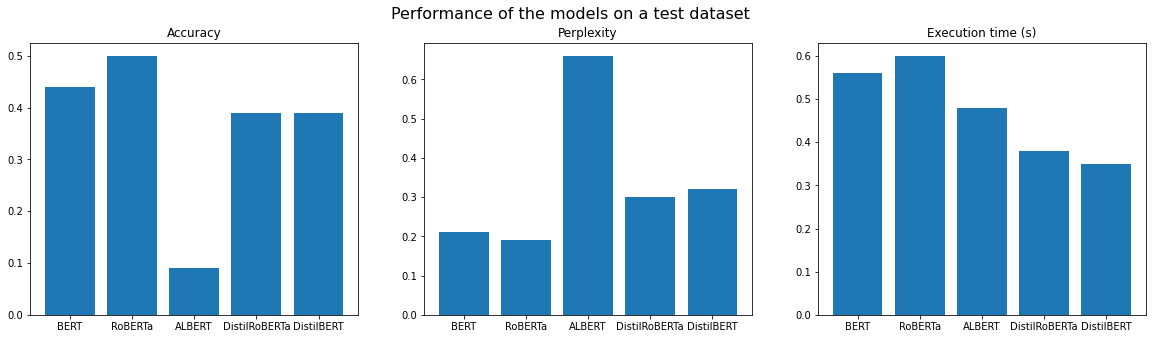

In [74]:
import matplotlib.pyplot as plt
accuracy = [0.44, 0.5, 0.09, 0.39, 0.39]
perplexity = [0.21, 0.19, 0.66, 0.3, 0.32]
execution_time = [0.56, 0.6, 0.48, 0.38, 0.35]

bins = ["BERT", "RoBERTa", "ALBERT", "DistilRoBERTa", "DistilBERT"]

# Visualize the accuracy, perplexity and execution time of each model in a bar chart all in the same plot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].bar(bins, accuracy)
ax[0].set_title("Accuracy")
ax[1].bar(bins, perplexity)
ax[1].set_title("Perplexity")
ax[2].bar(bins, execution_time)
ax[2].set_title("Execution time (s)")

# add title
fig.suptitle("Performance of the models on a test dataset", fontsize=16)

plt.show()


